# Exploratory Data Analysis

#### Below I took a look at the underlying Distribution and frequency statistics in order to determine which features to use for my Domain Features Classification modeling

In [1]:
#import packages
#general 
import pandas as pd
import numpy as np
# import itertools
# from collections import Counter

#visualization packages
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import Audio
from IPython.display import display

#file reading
import glob
import os

#audio signal processing
from scipy import fftpack
from scipy import signal
from scipy.io import wavfile
from scipy.signal import find_peaks


# DataSet

#### Sound Classes (20 X 30s audio samples for each)
* [Fire Alarm](https://www.youtube.com/watch?v=nIfIAgkB-MI)
* Song
    - (5) Folsom Prison Blues - Johnny Cash
    - (5) Cocoa Butter Kisses - Chance the Rapper
    - (5) 3005 - Childish Gambino
    - (5) Alive with the Glory of Love - Say Anything
* Microwave
* Blender
* Vacuum
* Silence


## Read and Collect Audio File Info

In [2]:
#create df to store file labels and paths 
audioInfo_DF = pd.DataFrame(columns = ['label', 'name', 'path'])

#cycle through each folder and wav file
for file in glob.glob('data/*/*.wav'):
    #create DFrow dictionary to hold row information that will be appended
    dfRow = {}
    pathList = file.split('\\')
    dfRow['label'] = pathList[-2]
    dfRow['name'] = pathList[-1]
    dfRow['path'] = file
    #add file label, name, and path to DF
    audioInfo_DF=audioInfo_DF.append(dfRow, ignore_index=True)

audioInfo_DF.head()

,label,name,path
0,alarm,alarm102019_10_06_10_03_49.wav,data\alarm\alarm102019_10_06_10_03_49.wav
1,alarm,alarm12019_10_06_09_54_08.wav,data\alarm\alarm12019_10_06_09_54_08.wav
2,alarm,alarm22019_10_06_09_55_03.wav,data\alarm\alarm22019_10_06_09_55_03.wav
3,alarm,alarm312019_10_07_16_35_07.wav,data\alarm\alarm312019_10_07_16_35_07.wav
4,alarm,alarm32019_10_06_09_55_56.wav,data\alarm\alarm32019_10_06_09_55_56.wav


# Test Median Filtering rates

#### I'll be applying some measure of median filtering to the audio file data just to smooth out the noise. First, I'll check the filter sizes against the Audio player to ensure not too much data is lost

#### Top Player = No Filter
#### Bottom Player = Median Filter

In [3]:
#create an interactive audio player to listen to listen to the files
@interact(idx=(0,len(audioInfo_DF)))
def playAudio(idx):
    rate, amp = wavfile.read(os.path.abspath(audioInfo_DF['path'][idx])) #read in file
    #show amplitude chart
    time = np.arange(0, amp.size/rate, 1/rate)
    plt.plot(time[10000:10100], amp[10000:10100])
    plt.title('Audio Recording: %d'%idx)
    plt.xlabel('Seconds')
    plt.ylabel('Amplitude')
    plt.show()
    #Display audio player
    display(Audio(amp, rate=rate))
    
    # apply filter and create another player
    amp = signal.medfilt(amp,11)
    
    
    #show amplitude chart
    time = np.arange(0, amp.size/rate, 1/rate)
    plt.plot(time[10000:10100], amp[10000:10100])
    plt.title('Audio Recording: %d'%idx)
    plt.xlabel('Seconds')
    plt.ylabel('Amplitude')
    plt.show()
    #Display audio player
    display(Audio(amp, rate=rate))

interactive(children=(IntSlider(value=65, description='idx', max=130), Output()), _dom_classes=('widget-intera…

# Compare Frequencies Between Classes

In [4]:
def loadWave(idx):
    #get read rate and time series amplitude from wav file
    rate, amp = wavfile.read(audioInfo_DF['path'][idx])
    amp = amp.astype(float) # convert to float
    return rate, amp

In [5]:
#create formula for extracting frequency peaks
def calcFilterSize(rate):
    '''
    Calculates integer filter size to use based on audios sampling rate
    return: odd integer
    '''
    SizeToRateRatio = 101/44100
    filterSize = int(rate * SizeToRateRatio)
    #ensure filter Size is odd
    if filterSize%2 != 1:
        filterSize += 1
    return filterSize

def getFFT(rate, amp):
    '''
    input: audio sampling rate, (float)
            amplitude readings, (np.array)
    output: 
            top n frequency peak frequencies, (np.array)
            top n frequency peak amplitudes, (np.array)
    '''
    #normalize amplitudes
    amp = amp.astype(float) # convert to float
    amp = (amp - amp.mean())/ np.max(np.abs(amp)) # normalize
    
    #change signal to frequency domain
    freqAmp = abs(fftpack.fft(amp))
    freqList = fftpack.fftfreq(len(amp)) * rate
    
    #slice arrays to remove frequency reflection
    freqAmp = freqAmp[range(len(freqAmp)//2)]
    freqList = freqList[range(len(freqList)//2)]
    
    #apply median filtering to FFT to isolate peaks
#     filterSize = calcFilterSize(rate)
#     freqAmp = signal.medfilt(freqAmp,filterSize)
    
    #downsample the frequency list to 1 point for each hertz
    downSample = int(1/(freqList[1]-freqList[0]))
    freqAmp = np.array([freqAmp[i*downSample : (i*downSample + downSample)].max() for i in range(len(freqAmp)//downSample)])
    freqList = np.array((range(len(freqList)//downSample)))
    
    return (freqList, freqAmp)

Class "alarm" Frequency Domain


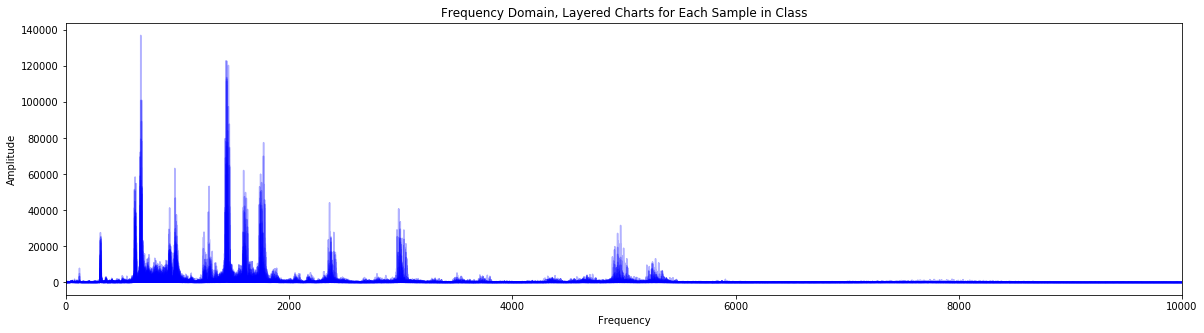

Class "blender" Frequency Domain


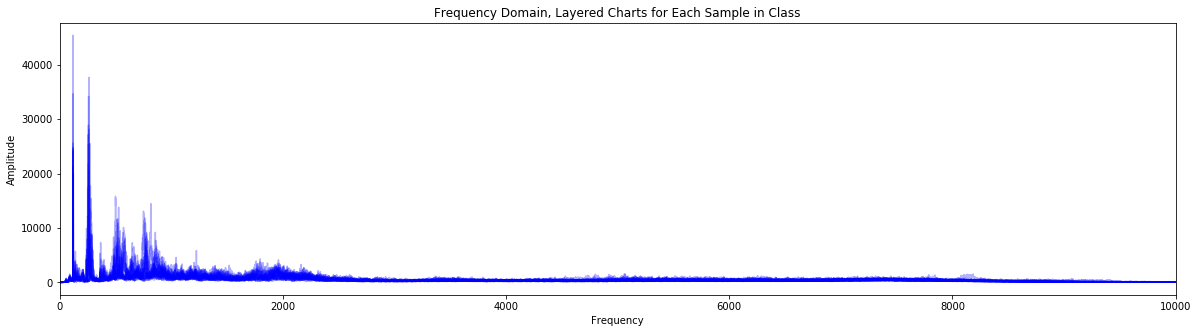

Class "microwave" Frequency Domain


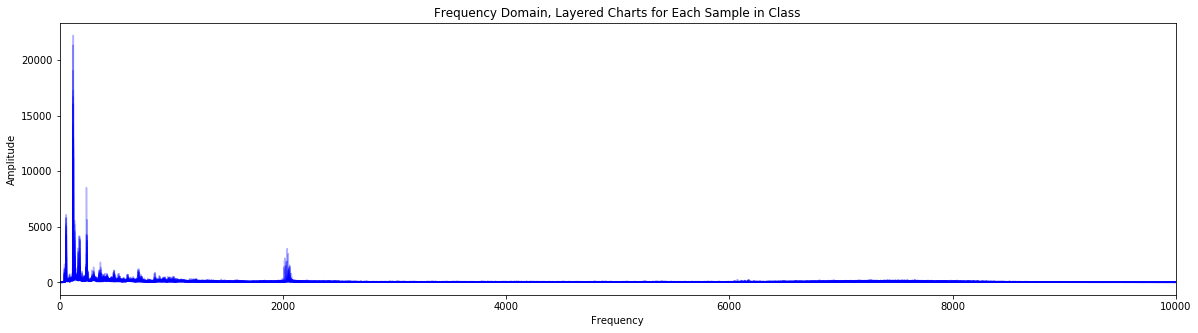

Class "silent" Frequency Domain


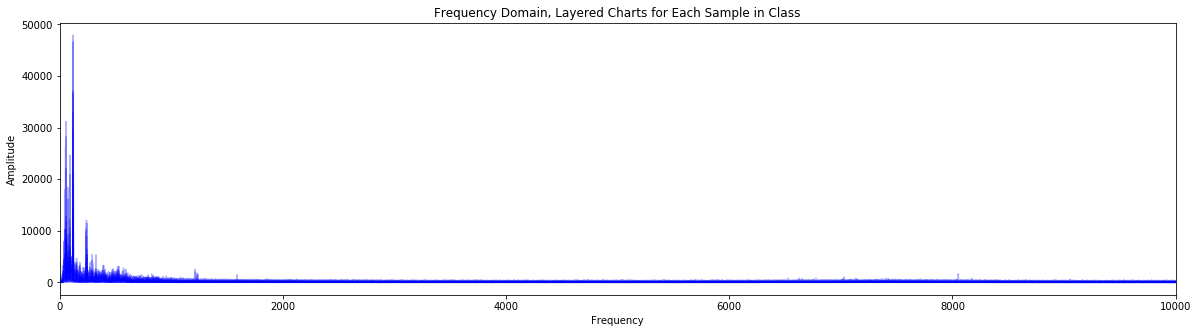

Class "songs" Frequency Domain


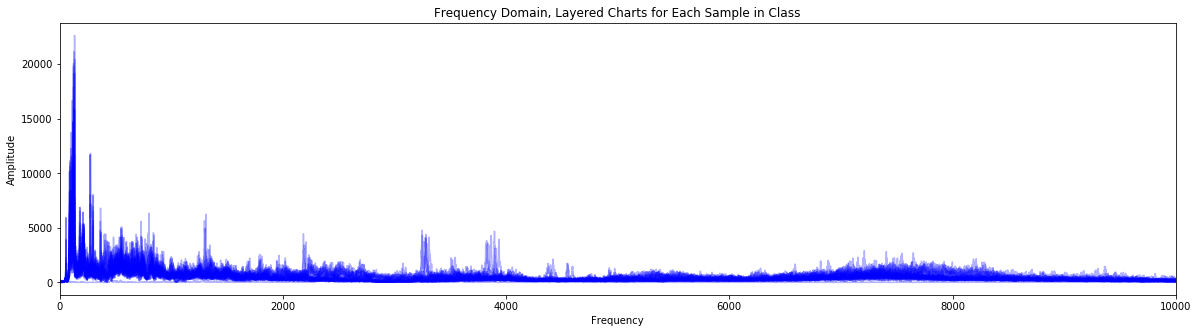

Class "vacuum" Frequency Domain


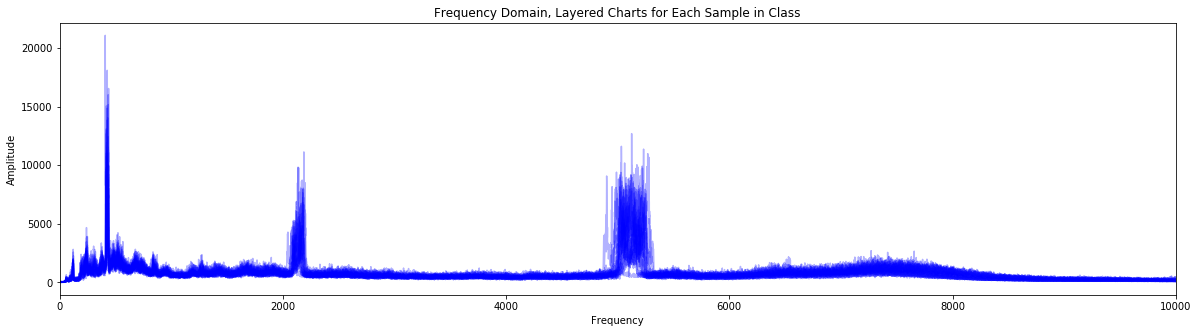

In [6]:
from matplotlib.pyplot import figure

#select 1 random sample from each class to compare
classes = audioInfo_DF['label'].unique()
for c in classes:
    #get indexes for class
    cInd = [i for i in range(len(audioInfo_DF['label'])) if audioInfo_DF['label'][i] == c]
    print("Class \"" + c + "\" Frequency Domain")
    figure(figsize=(20,5))
    #chart each FFT transparently
    for i in cInd:
        freqList, freqAmp = getFFT(*loadWave(i))
        plt.plot(freqList, freqAmp, linestyle='-', color='blue', alpha=0.3)
        plt.xlim(0,10000)
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude')
        plt.title("Frequency Domain, Layered Charts for Each Sample in Class")
    plt.show()

Class "alarm" Frequency Domain


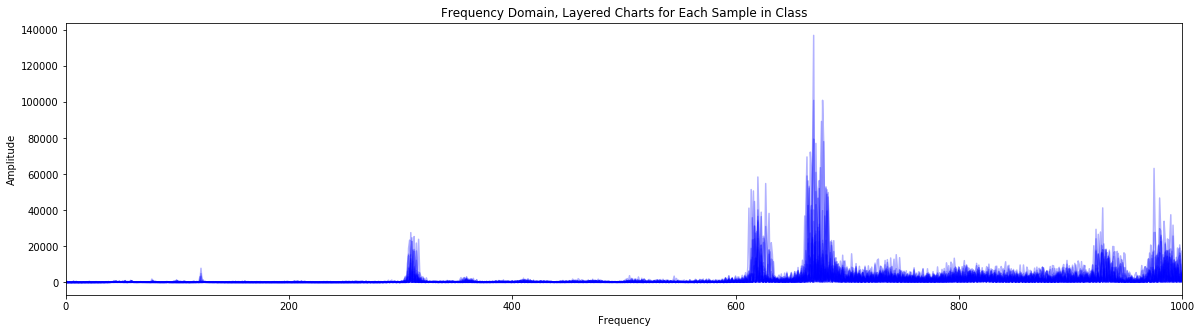

Class "blender" Frequency Domain


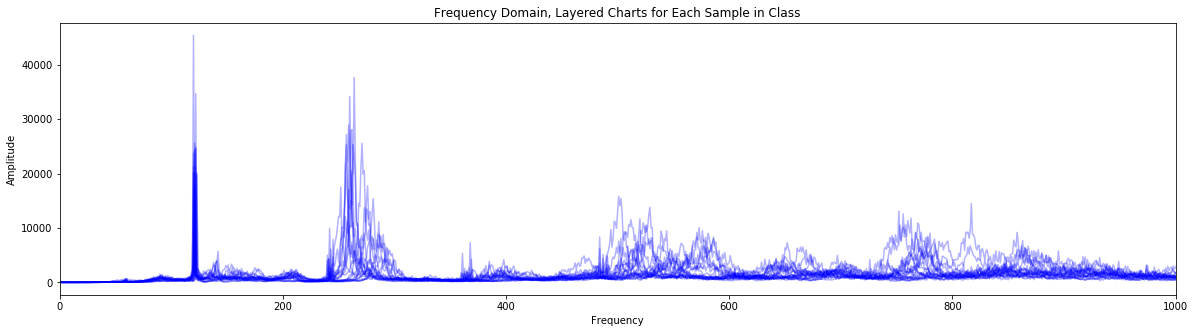

Class "microwave" Frequency Domain


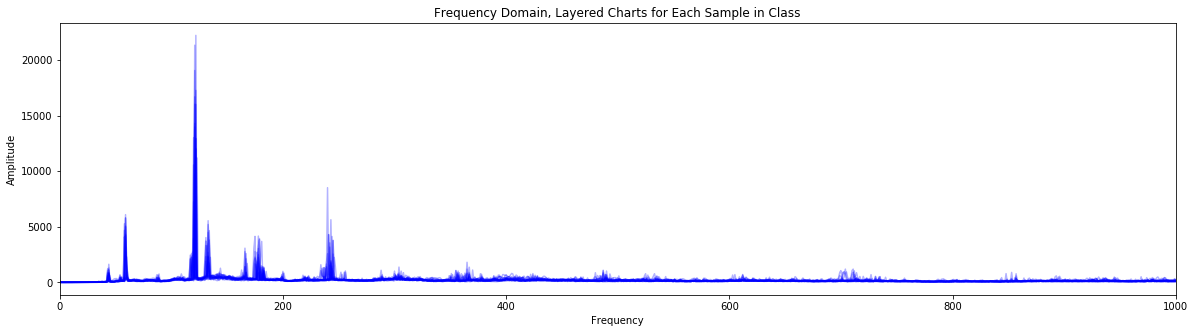

Class "silent" Frequency Domain


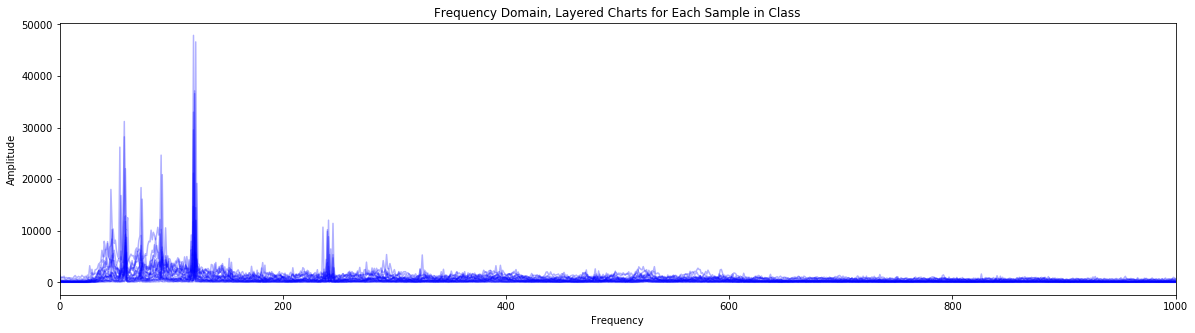

Class "songs" Frequency Domain


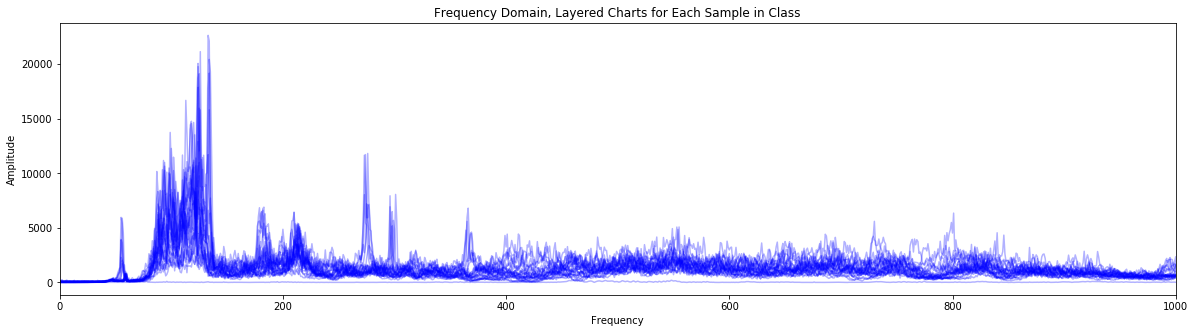

Class "vacuum" Frequency Domain


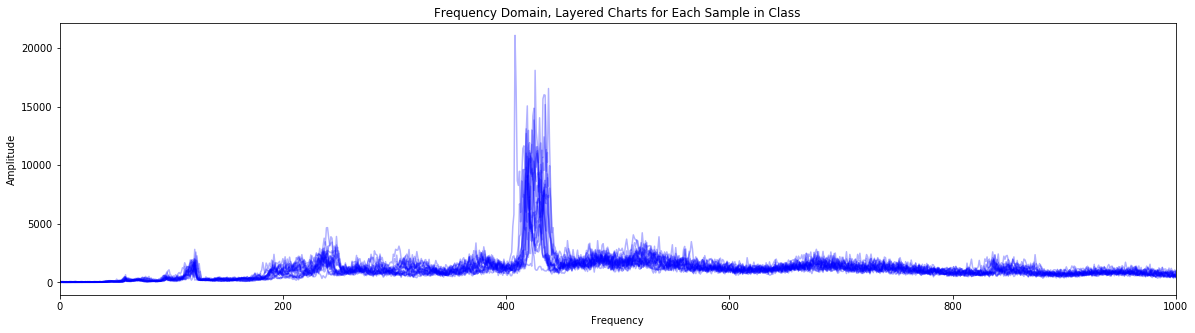

In [7]:
#It appears 10,000HZ and over can be eliminated.
#most of the overlap appears at 0-1000
#Zoom In
classes = audioInfo_DF['label'].unique()
for c in classes:
    #get indexes for class
    cInd = [i for i in range(len(audioInfo_DF['label'])) if audioInfo_DF['label'][i] == c]
    print("Class \"" + c + "\" Frequency Domain")
    figure(figsize=(20,5))
    #chart each FFT transparently
    for i in cInd:
        freqList, freqAmp = getFFT(*loadWave(i))
        plt.plot(freqList, freqAmp, linestyle='-', color='blue', alpha=0.3)
        plt.xlim(0,1000)
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude')
        plt.title("Frequency Domain, Layered Charts for Each Sample in Class")
    plt.show()

# Compare Distributional Statistics

In [8]:
def getDistFeatures(rate, amp):
    '''
    input: sampling rate (float)
            amplitudes (np.array)
    output:
             distributional features of the audio amplitudes
    '''
    featureDict = {}
    featureDict['median'] = np.median(abs(amp)) #medianAmp
    featureDict['Perc95'] = np.percentile(abs(amp), 95) #maxAmp
    featureDict['stDev'] = np.std(amp)
    return featureDict

In [9]:
features = ['median','Perc95', 'stDev']
distFeatures_DF = pd.DataFrame(columns=['id', 'label', 'median','Perc95', 'stDev'])
for idx in range(len(audioInfo_DF)):
    featureDict = getDistFeatures(*loadWave(idx))
    featureDict['id'] = idx
    featureDict['label'] = audioInfo_DF['label'][idx]
    distFeatures_DF = distFeatures_DF.append(featureDict, ignore_index=True)
print(len(distFeatures_DF))

130


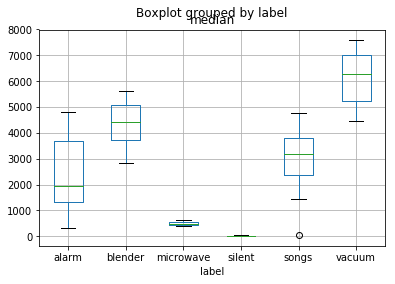

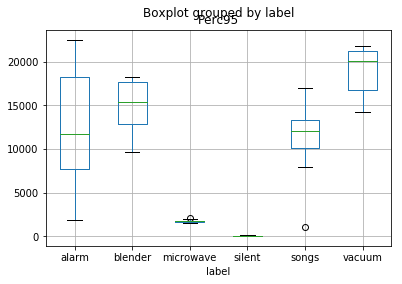

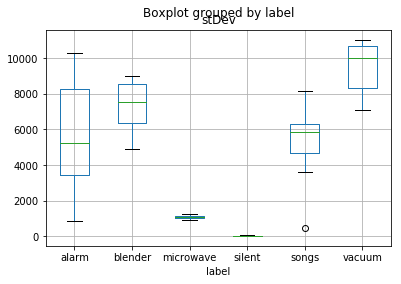

In [10]:
#compare distributional statistics by class
for f in features:
    distFeatures_DF.boxplot(column=f, by='label')